In [ ]:
# Install HuggingFace Transformers and Datasets
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# Install scikit-learn for evaluation metrics
!pip install scikit-learn

In [ ]:
# AraBERT uses a custom Arabic preprocessor
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 12.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=4f06cb603d1b2f9f7c191ed6dbb8de9c79ea5259378af8b2235e8b3a5504407e
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# Load Dataset 
file_path = "/content/drive/MyDrive/AraBERT_GPU_Results.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

In [ ]:
# Use rows that now have predicted_label 
texts = df[df["predicted_label"].notna()]["normalization + translated"].astype(str).tolist()
labels = df[df["predicted_label"].notna()]["predicted_label"].astype(int).tolist()

In [ ]:
# Split Data 
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
# Tokenizer & Model 
model_name = "/content/drive/MyDrive/arabert_GPU_initial_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

In [ ]:
# Retrain Model 
num_labels = len(set(labels))
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

In [ ]:
# Training Setup 
training_args = TrainingArguments(
    output_dir="./arabert_retrained_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Retrain the Model 
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seniorprojectbtsa (seniorprojectbtsa-imam-abdulrahman-bin-faisal-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.216200,0.219955,0.915973
2,0.145800,0.238593,0.924709
3,0.060500,0.268407,0.931780


TrainOutput(global_step=1803, training_loss=0.17255400732589377, metrics={'train_runtime': 738.1832, 'train_samples_per_second': 39.068, 'train_steps_per_second': 2.442, 'total_flos': 1896981963464448.0, 'train_loss': 0.17255400732589377, 'epoch': 3.0})

In [ ]:
# Evaluate Accuracy 
val_preds = trainer.predict(val_dataset)
val_predictions = np.argmax(val_preds.predictions, axis=1)

In [ ]:
print("\nRetraining Accuracy:", accuracy_score(val_labels, val_predictions))
print("\nClassification Report:\n", classification_report(val_labels, val_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(val_labels, val_predictions))


Retraining Accuracy: 0.9159733777038269

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       299
           1       0.63      0.65      0.64       264
           2       0.98      0.95      0.97      1841

    accuracy                           0.92      2404
   macro avg       0.81      0.84      0.82      2404
weighted avg       0.92      0.92      0.92      2404


Confusion Matrix:
 [[ 276   19    4]
 [  61  172   31]
 [   4   83 1754]]


In [ ]:
# Save Retrained Model 
trainer.save_model("/content/drive/MyDrive/AraBERT_GPU_Retrained_Model")
tokenizer.save_pretrained("/content/drive/MyDrive/AraBERT_GPU_Retrained_Model")
print("Retrained model saved in folder 'AraBERT_GPU_Retrained_Model'")

Retrained model saved in folder 'AraBERT_GPU_Retrained_Model'


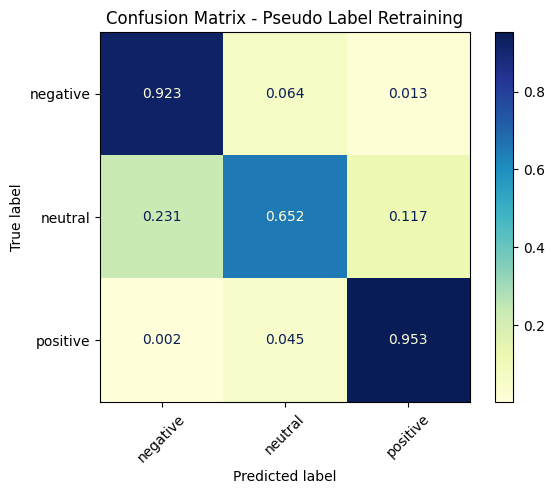

In [ ]:
# Plot Confusion Matrix 
cm = confusion_matrix(val_labels, val_predictions, normalize="true")
labels_display = ["negative", "neutral", "positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap="YlGnBu", values_format=".3f", xticks_rotation=45)
plt.title("Confusion Matrix - Pseudo Label Retraining")
plt.savefig("/content/drive/MyDrive/Images/Confusion Matrix - Pseudo Label Retraining.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test and validation sets
pred_test = trainer.predict(train_dataset)
pred_val = trainer.predict(val_dataset)

# Extract true and predicted labels
y_true_test = pred_test.label_ids
y_pred_test = pred_test.predictions.argmax(axis=-1)

y_true_val = pred_val.label_ids
y_pred_val = pred_val.predictions.argmax(axis=-1)

# Generate classification reports
report_test = classification_report(y_true_test, y_pred_test, target_names=["Positive", "Neutral", "Negative"], output_dict=True)
report_val = classification_report(y_true_val, y_pred_val, target_names=["Positive", "Neutral", "Negative"], output_dict=True)

# Format as DataFrame
df_test = pd.DataFrame(report_test).transpose()
df_val = pd.DataFrame(report_val).transpose()

# Add Accuracy manually
accuracy_test = accuracy_score(y_true_test, y_pred_test)
accuracy_val = accuracy_score(y_true_val, y_pred_val)

# Display results
print("Test Set Classification Report")
print(df_test)
print(f"Accuracy: {accuracy_test:.4f}\n")

print("Validation Set Classification Report")
print(df_val)
print(f"Accuracy: {accuracy_val:.4f}")


Test Set Classification Report
              precision    recall  f1-score      support
Positive       0.869565  0.970089  0.917081  1237.000000
Neutral        0.787912  0.706404  0.744935  1015.000000
Negative       0.982657  0.977585  0.980114  7361.000000
accuracy       0.947987  0.947987  0.947987     0.947987
macro avg      0.880045  0.884692  0.880710  9613.000000
weighted avg   0.947542  0.947987  0.947172  9613.000000
Accuracy: 0.9480

Validation Set Classification Report
              precision    recall  f1-score      support
Positive       0.809384  0.923077  0.862500   299.000000
Neutral        0.627737  0.651515  0.639405   264.000000
Negative       0.980436  0.952743  0.966391  1841.000000
accuracy       0.915973  0.915973  0.915973     0.915973
macro avg      0.805852  0.842445  0.822765  2404.000000
weighted avg   0.920429  0.915973  0.917561  2404.000000
Accuracy: 0.9160


In [ ]:
# Display Hyperparameters
import pandas as pd

hyperparameters = {
    "Parameter": [
        "Maximum sequence length", "Train Batch size", "Evaluation Batch size", "Number of epochs",
        "Logging steps", "Save total limit", "Save strategy", "Evaluation strategy", "Load best model at end"
    ],
    "Value": [
        128, 16, 64, 3,
        10, 2, "epoch", "epoch", True
    ]
}

df_hyperparams = pd.DataFrame(hyperparameters)
print("Hyperparameters for BERT Model")
from IPython.display import display
display(df_hyperparams.style.hide(axis="index"))


Hyperparameters for BERT Model


Parameter,Value
Maximum sequence length,128
Train Batch size,16
Evaluation Batch size,64
Number of epochs,3
Logging steps,10
Save total limit,2
Save strategy,epoch
Evaluation strategy,epoch
Load best model at end,True


### CLOSE